# Mstar Demo

In this notebook, you find how to use Mstar and output predictions. Also, you will get familiarised with the ANN model functionalities.

In [1]:
# import mstar as Mstar

In [21]:
import sys
import os
import pickle
from pathlib import Path
import numpy as np
from sklearn.neural_network import MLPRegressor, MLPClassifier

# local folder
# from .utils import load_cosmos_sample, create_directories

# utils functions
def get_project_root():
    return str(Path(os.getcwd()).absolute().parent)

def load_cosmos_sample(label,kind='smass', path='./data/lib/'):
    """Loads COSMOS training/test data."""
    x_train = np.load(path+'x_%s.npy'%label)
    y_train = np.load(path+'y_%s.npy'%label)

    ix = np.where(kind=='smass', 0, 1)
    
    return x_train, y_train[:,ix]

def write_model(model, fname):
    with open(fname, 'wb') as f:
        d = pickle.dump(model, f)
    pass

def load_model(fname):
    with open(fname, 'rb') as f:
        d = pickle.load(f, encoding='bytes') 
    return d

def create_directories(path):
    # Define directories
    model_folder = 'model/'
    plot_folder = 'plots/'

    # Create model directory
    _makedirs(path)
    _makedirs(path + model_folder)
    _makedirs(path + plot_folder)

def _makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    pass

# conf function
def set_ann_params(kind):
    """
    All hyperparameters for the ann algorithm can be tuned here. For a detailed description of each hyperparameter
    please visit: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html.
    The most important hyperparameters are hidden_layer_sizes, activation='relu'.
    """
    params = {'hidden_layer_sizes': (100,),
              'activation': 'relu'
              }
    return params
    
root = get_project_root()
default_model_fname =  {'smass':root+'/data/model/ann.pkl', 'quenching': root+'/data/model/classifier_ann.pkl'}

class Mstar:
    """
    Top-level class for training or loading the saved ANN model for stellar mass and quenching label predictions.
    The code is based on the the scikit-learn library and api.

    Parameters
    ----------
    kind: str, optional
        Specifies the prediction mode you will use. The string has to be "smass" or "quenching".

    model_fname: st, optional
        Sets the model filename to be loaded. Default filename is `./models/ann3`.
        
    outdir: bool, optional
        The path to save the estimated values, plots and the model.
    """

    def __init__(self, kind='smass', model_fname=None, rebuild=False, root=root):
        # Initialise arguments
        self.kind = kind
        
        # default ANN model file
        if model_fname is None:
            model_fname = default_model_fname[self.kind]
            
        self.model_fname = model_fname
        
        # Define directory paths
        self.path = root+'/data/'
        self.lib_folder = self.path+'/lib/'
        self.plot_folder = self.path+'plots/'
        self.model_folder = self.path+'model/'

        # Check if model_name exists
        if os.path.isfile(self.model_fname) & (not rebuild):
            # load model here
            self.model = load_model(self.model_fname)
            print('Loaded model {model}'.format(model=self.model_fname))
        elif rebuild:
            print('Rebuilding model. It might take few seconds.')
            self.rebuild()
            
            print('Created default model file succsefully: {dfname}'.format(dfname=default_model_fname[self.kind]))
            
        else:
            print('Model error: {fname} file not found. To run Mstar specify the correct model path/name.'.format(fname=self.model_fname))
            print('If there is no {dfname}, set rebuild to True'.format(dfname=default_model_fname[self.kind]))    
            #exit()

    def predict(self, X):
        """Predicts the value of the model

        The default is to predict the stellar masses. 
        In the classifying a quenched galaxy returns the quenching probability. 
        
        Parameters
        ----------
        X : array
            An array of input features of galaxies with shape [n, x], where n is the number of galaxies and x is the number of input features.
            
        Returns
        ----------
        Y : array
            An array of predicted values with size n
        """
        # Use the model to make predictions on new objects
        y_pred = self.model.predict(self.x_test)

        # Update class variables
        #self.plot.y_pred = y_pred
        
#         if self.kind=='quenching':
#             # quenching probability
#             y_pred = y_pred[:,0]
        
        return y_pred
    
    def rebuild(self):
        # set default fname
        self.model_fname = default_model_fname[self.kind]
        # load training files
        self.load_training_sample()
        # fit data and save the model
        self.fit(self.x_train, self.y_train, save_model=True)
    
    def fit(self, X, y, ann_params=None, save_model=True):
        """fit a new ANN model

        Fit a new ANN model. 
        You can set the best params with ann_params. 

        Parameters
        ----------
        X : array
            An array of input features of training galaxies with shape [n, x], where n is the number of galaxies and x is the number of input features.
        
        y : array
            An array of target features of training galaxies with shape [n, y], where n in the number of galaxies and y is the number of target features.

        ann_params: dict, optional
            If none sets the default ann_params. Otherwise, take a look at the sklearn api.
        
        save_model: bool, optional
            Whether to save model or not.
        """
        # Create the model directory
        create_directories(self.path)
        
        if ann_params is None:
            # Get random forest hyperparameters
            self.params = set_ann_params(self.kind)

        func_dict = {'smass':MLPRegressor, 'quenching': MLPClassifier}
        func = func_dict[self.kind]
        
        # Train model
        print('Training model...')
        self.model = func(**self.params)
        self.model.fit(X, y)
                
        # Save model
        if save_model:
            write_model(self.model, self.model_fname)
            print('Saved model')

    # External Class functions
    def load_training_sample(self):
        x_train, y_train = load_cosmos_sample('train', self.kind, self.lib_folder)
        # set training variables
        self.x_train = x_train
        self.y_train = y_train
        pass
        
    def load_test_sample(self):
        x_test, y_test = load_cosmos_sample('test', self.kind, self.lib_folder)
        self.x_test = x_test
        self.y_test = y_test
        pass

    def load_target_sample(self):
        x_test, y_test = load_cosmos_sample('target', self.kind, self.lib_folder)
        self.x_target = x_test
        self.y_tartet = y_test
        pass

    def plot_scatter(self, show=False, save=True):
        print('Creating scatter plots...')
        return self.plot.plot_scatter(show=show, save=save)

    def plot_joint(self, show=False, save=True):
        print('Creating posterior plots...')
        return self.plot.plot_joint(show=show, save=save)


In [22]:
mS = Mstar('smass',rebuild=True)

Rebuilding model. It might take few seconds.
Training model...
Saved model
Created default model file succsefully: /Users/jesteves/Documents/GitHub/mstar-alpha/data/model/ann.pkl


In [23]:
mS.load_training_sample()

In [24]:
mS.y_train

array([10.3462 , 10.3462 , 10.2143 , ...,  9.23365,  9.23365,  7.87907])

In [25]:
mS.load_test_sample()
ypred = mS.predict(mS.x_test)

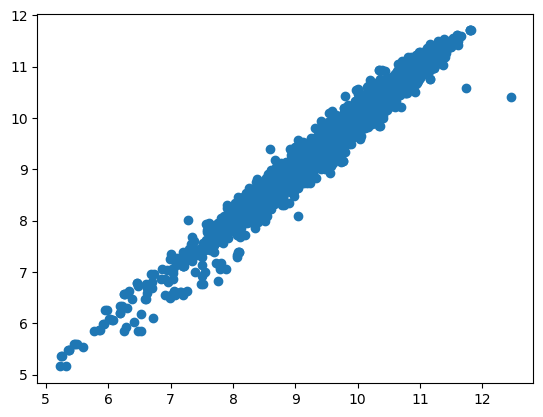

In [26]:
import matplotlib.pyplot as plt
plt.scatter(ypred, mS.y_test)

In [28]:
mS = Mstar('quenching',rebuild=True)

Rebuilding model. It might take few seconds.
Training model...
Saved model
Created default model file succsefully: /Users/jesteves/Documents/GitHub/mstar-alpha/data/model/classifier_ann.pkl


In [29]:
mS.load_training_sample()

In [30]:
Pq = mS.predict(mS.x_test)

AttributeError: 'Mstar' object has no attribute 'x_test'

In [ ]:
plt.hist(Pq)

In [ ]:
# ms.plot.color_evolution(Pq, X)